# Introduction to Julia

## the programming language for 21 Century

by Randy Lai

## Assumption

I assume you know at least one of them
- Python
- R
- MATLAB

## What is Julia?

<img src="julialogo.png" width=100> </img>

- a new programming language for scientific computing (9 years old)
    - R (26 years old)
    - Python (30 years old)
    - MATLAB (37 years old)
- developed by a (young) group mostly from MIT
- open source
- AFAIK, Julia is not named after any girl.

### How does Julia look like?

In [1]:
a = 2 + 2
b = a - 3
c = a * 3
d = 4 / 5  # life saver
print([a; b; c; d])

[4.0, 1.0, 12.0, 0.8]

It is designed to do math.

Use unicodes and greek letters as variables

In [43]:
ϕ(x̅; μ=0, σ²=1) = exp( -(x̅ - μ)^2 / 2σ²) / √(2π * σ²)
ϕ(1)

0.24197072451914337

Do not need replace σ² by `sigmasq`

In [45]:
f(x) = x^2
g(y) = y + 1
h = f ∘ g;
h(2)

9

In [4]:
10_000

10000

In [5]:
0.000_000_005

5.0e-9

A beer costs $5. How much are two beers?

In [6]:
🍺 = 5
🍻 = 2🍺

10

Yes! Julia supports Emojis as variables too.

## Why do I need to know about it?

(it just looks fancy to me)

|                        Test                        | R 3.3.2 | Matlab R2017a | Julia 0.5.1 |
|:-------------------------------------------------- |:-------:|:-------------:|:-----------:|
| Matrix creation, trans., deform. (2500 x 2500) |   0.70  |      **0.13**     |   0.22  |
|      Power of matrix (2500 x 2500, `A.^1000`)      |   0.17  |    **0.10**   |     0.11    |
|          Quick sort ($n = 7 \times 10^6$)          |   0.69  |    **0.30**   |     0.62    |
|         Cross product (2800 x 2800, $A^TA$)        |  13.49  |    **0.18**   |  0.21  |
|            LS solution ($n = p = 2000$)            |   6.42  |    **0.07**   |     **0.07**    |
|                FFT ($n = 2,400,000$)               |   0.25  |    **0.03**   |     0.16    |
|           Eigen-values ($600 \times 600$)          |   0.71  |    **0.22**   |     0.51    |
|          Determinant ($2500 \times 2500$)          |   3.49  |      0.19     |   **0.14**  |
|            Cholesky ($3000 \times 3000$)           |   5.03  |    **0.08**   |     0.16    |
|         Matrix inverse ($1600 \times 1600$)        |   2.83  |    **0.11**   |     0.18    |
|           Fibonacci (vector calculation)           |   0.22  |    **0.16**   |     0.58    |
|            Hilbert (matrix calculation)            |   0.21  |      0.07     |   **0.06**  |
|                   GCD (recursion)                  |   0.33  |    **0.09**     |   0.13  |
|               Toeplitz matrix (loops)              |   0.28  |     0.0012    |  **0.0007** |
|                 Escoufiers (mixed)                 |   0.33  |      0.15     |   **0.14**  |


(from Hau Zhou: http://hua-zhou.github.io/)

### MATLAB users: don't get happy too early

<img src="benchmark2.png" width="800px" align="center"> </img>

## Why does Julia work so well?

1. Just in time (JIT)

    every statement is run using compiled functions
    
2. type stability via multiple dispatch

    allows Julia to be very easy for a compiler to generate efficient code

Just in time (JIT)

In [7]:
x = randn(100)
@time sum(x); # first call invokes compilation
@time sum(x); # second run doesn't need compilation anymore

  0.042155 seconds (9.81 k allocations: 557.752 KiB)
  0.000002 seconds (5 allocations: 176 bytes)


In [47]:
@code_native sum(x)

	.section	__TEXT,__text,regular,pure_instructions
Filename: reduce.jl
	pushq	%rbp
	movq	%rsp, %rbp
Source line: 359
	callq	"indices;"
	popq	%rbp
	retq
Source line: 359
	nopl	(%rax,%rax)


Multiple dispatch

In [9]:
foo(x::Int) = "apple"
foo(x::Float64) = "orange"

foo (generic function with 2 methods)

In [10]:
foo(1)

"apple"

In [11]:
foo(2.0)

"orange"

### How can multiple dispatch speed up the computation? Consider this,

In [12]:
pow(x, y) = x^y

pow (generic function with 1 method)

In [13]:
pow(2, 2)

4

In [14]:
pow(2.0, 2.0)

4.0

In [53]:
# pow(2, -2)

LoadError: DomainError:
Cannot raise an integer x to a negative power -n. 
Make x a float by adding a zero decimal (e.g. 2.0^-n instead of 2^-n), or write 1/x^n, float(x)^-n, or (x//1)^-n.

Type stability is one crucial feature which separates Julia apart from other scripting languages.

In [55]:
@code_llvm 2^2


define i64 @"jlsys_^_53303"(i64, i64) #0 !dbg !5 {
top:
  %2 = call i64 @jlsys_power_by_squaring_53305(i64 %0, i64 %1)
  ret i64 %2
}


In [17]:
@code_llvm 2.0^2.0


define double @"jlsys_^_53315"(double, double) #0 !dbg !5 {
top:
  %2 = call double @llvm.pow.f64(double %0, double %1)
  %3 = fadd double %0, %1
  %notlhs = fcmp ord double %2, 0.000000e+00
  %notrhs = fcmp uno double %3, 0.000000e+00
  %4 = or i1 %notrhs, %notlhs
  br i1 %4, label %L8, label %if

if:                                               ; preds = %top
  call void @jl_throw(i8** inttoptr (i64 4555392968 to i8**))
  unreachable

L8:                                               ; preds = %top
  ret double %2
}


If you insist, you may consider the following safe option.

In [18]:
function safe_pow(x, y)
    if y > 0
        x^y
    else
        Float64(x)^y
    end
end

safe_pow (generic function with 1 method)

In [19]:
safe_pow(2, -2)  # it is what python/R offer

0.25

In [57]:
#@code_llvm safe_pow(2, -2)

## Language features of R, Matlab and Julia

|        Features       |             R            |     Matlab     |        Julia        |
|:---------------------:|:------------------------:|:--------------:|:-------------------:|
|      Open source      |           👍         |      👎      |         👍        |
|          IDE          |    RStudio 👍 👍     | 👍 👍 👍 |    Atom+Juno 👎   |
|    Dynamic document   | RMarkdown 👍 👍 👍 |    👍 👍   |   IJulia + Jupyter 👍 👍  |
|          JIT          |    `compiler` 👎  |    👍 👍   |    👍 👍 👍   |
|     Call C/Fortran    |      wrapper, `Rcpp`     |     wrapper    | direct call |
|         Type system        |           👎           |    👍 👍   |    👍 👍 👍   |
|   Pass by reference   |           👎           |      👎      |    👍 👍 👍   |
|     Linear algebra    |           👎           |   MKL, Arpack  |  OpenBLAS, eigpack  |
|    Multi-threading    |    `parallel` 👎  |      👍      |  👍 👍  |
| Distributed computing |           👎           |      👍      |    👍 👍 👍   |
| Sparse linear algebra |  `Matrix` package 👎   | 👍 👍 👍 |    👍 👍 👍   |
|     Documentation     |           👎           | 👍 👍 👍 |      👍 👍      |
|        Profiler       |           👎           | 👍 👍 👍 |    👍 👍 👍   |

(from Hau Zhou: http://hua-zhou.github.io/)

## Parallel Computing support

Julia makes parallel computing very easy.

### Multi threading

In [6]:
using Distributed
addprocs(4);  # add 4 processes

We may have an expensive call to evaluate and it may take up to 4 seconds.

In [7]:
r = @spawn begin 
    sleep(4)  # pretend that it is very expensive command
    return 2017
end
# while the call is evaluated in other thread,
# you are free to do anything now
x = 100

100

In [8]:
fetch(r)

2017

### Doing distributed calcuations

Say for example, we have 4 tasks to do and each task takes 1 second.

A regular for loop needs about 4 seconds to complete the job.

In [24]:
@time for i = 1:4
    sleep(1) 
end

  4.013434 seconds (814 allocations: 45.234 KiB)


With parallel computing

In [25]:
@time @sync @parallel for i = 1:4
    sleep(1)
end

  1.586171 seconds (92.09 k allocations: 5.092 MiB)


4-element Array{Future,1}:
 Future(3, 1, 8, #NULL) 
 Future(4, 1, 9, #NULL) 
 Future(5, 1, 10, #NULL)
 Future(2, 1, 11, #NULL)

## How else Julia offers?

There are are over 4000 registered packages on https://juliapackages.com/.



### Data Visualization

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Saved animation to 
│   fn = /Users/Randy/Dropbox/Winter2021/sta141c/sta141c-lectures/julia/tmp.gif
└ @ Plots /Users/Randy/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/Randy/Dropbox/Winter2021/sta141c/sta141c-lectures/julia/tmp.gif")
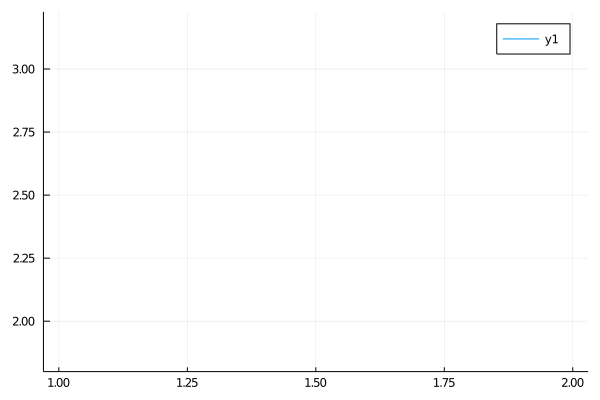

In [1]:
using Plots
x = randn()
p = plot([x])
@gif for i in 1:100
    x += randn()
    push!(p, x)
end

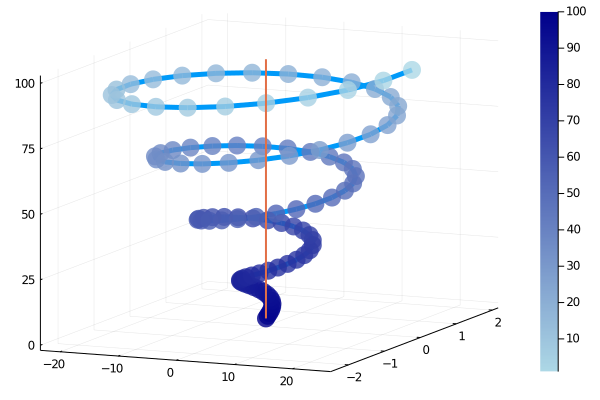

In [4]:
n = 100
ts = range(0,8π, length = n)
x = ts .* cos.(ts)
y = (0.1ts) .* sin.(ts)
z = 1:n
plot(x, y, z, zcolor=reverse(z), m = (10,0.8,:blues,stroke(0)), leg=false, cbar=true, w=5)
plot!(zeros(n), zeros(n), 1:n, w=2)

## But I really miss ggplot

No worries, there is RCall.jl


### Running R code in Julia

You could execute any R code inside 
```
R"<r code here>"
```

In [77]:
using RCall

x = rcopy(R"rpois(100, 5)")
mean(x)

5.24

- Plots.jl is good, but very slow to start up + I like `ggplot` of R

In [78]:
using DataFrames
x = randn(100)
y = 3 + 2x.^2 - 4x.^3 + 10.*randn(100)
D = DataFrame(x = x, y = y);

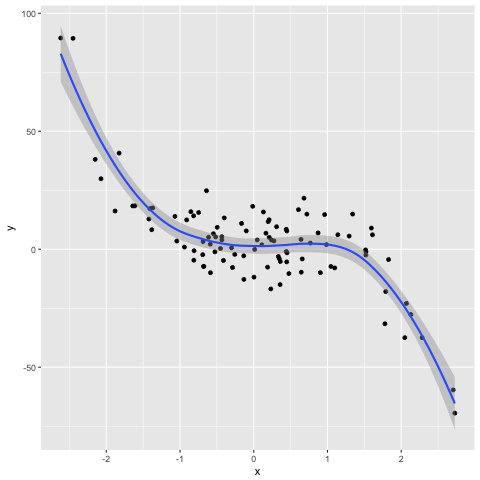

RCall.RObject{RCall.VecSxp}


In [79]:
R"""
library(ggplot2)
ggplot($D, aes(x, y)) + geom_point() + geom_smooth()
"""

## Summary

Julia is a very powerful programming language for Mathematicians/Statisticians/Scientists.

Please download it and have some try.

In [82]:
2//4 + 5//6

4//3